# Endogeneous Grid Method #
In this notebook we discuss how to solve the household problem a la Aiyagari--this is the main building block of most HANK models--with fast, optimized methods. The main reference for this notebook is Matt Rognlie's code on which you can find under https://github.com/shade-econ/nber-workshop-2023/blob/bc3bbba90ab575f09c4c8a9e77b0b2fe88812cd1/Lectures/Lecture%201%2C%20Standard%20Incomplete%20Markets%20Steady%20State.ipynb (2024).

## 1. **Incomplete Markets Model**
The standard incomplete markets model features the following timing:

- begin of period with asset returns $(1+r)a$ and stochastic income $y$.
- allocate to assets tomorrow $a'$ and consumption today $c$
- all subject to a borrowing constraint $a\geq \underline a$ and no ability to insure against idiosyncratic shocks: 
  $$ 
  \begin{gather}
    V(y, a) = \max_{c, a'} u(c) + \beta \mathbb E[V(e', a') | y] \\
    s.t.\; a' = (1+r)a + y - c \\
    a' \geq \underline a 
  \end{gather}
  $$

  We model the income process as an AR(1), so 
  $$ y_t = \rho y_{t-1} + e_t.$$
  Since we would like to solve the whole model on a finite grid $\mathcal{Y} \times \mathcal{A}$ with indices $(i_y, i_a)$, we need to discretize the income and the asset space. We already have functions to do this, applying the double-exponential grid space for assets, and the Rouwenhorst AR(1) process. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# some useful plot defaults$
plt.rcParams.update({'font.size' : 10, 'lines.linewidth' : 1.5, 'figure.figsize' : (4,3)})

**Exercise:** Write and import a class called `Grids` which if supplied the correct parameters outputs asset and income grids, as well as transition matrix and steady state for income.

In [2]:
from utils_simm import Grid

In [3]:
Grids = Grid(n_y = 10, rho = 0.975,  sd_log_y = 0.7, n_a = 100, min_a = 0, max_a = 10_000)

the steady state is unique.


## 2. **Backwards Iteration to Obtain Policy Functions**

It is more efficient and accurate to use envelope condition and FOC to iterate on marginal value function $V_a$ instead of finding the value function itself. We do backwards iteration in time. Let $a_t'(y_t, a_t)$ be the policy function for next-period asset holdings. Assume that $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$, where $\sigma$ is the elasiticity of intertemporal substitution (eis).

For backward iteration, we use the **Envelope condition**,
$$ V_{a,t}(e, a) = (1+r_t)u'(c_t(e, a))$$

and the **First-Order Condition** (inequality binds if borrowing limit binds) 

$$u'(c_t(y, a)) \geq \beta \mathbb E [V_{a, t+1}(y', a_t'(y, a))]|e]. $$

repeatedly:

**[Algorithm: Backward iteration in time]** 

Start at $t = T$, initialize $V_{a, T} = 1$. For $t< T$:
1. Use $V_{a, t+1}$ to calculate RHS of FOC
2. Solve for today's policies $a_t'(y, a)$, $c_t(y, a)$
3. Using envelope condition, obtain marginal value function of today $V_{a, t}$

We go through the steps in detail.

#### **Step 1** - Initialize, Set up Grids and Parameters

In [4]:
model_params = {
    'beta' : 0.95,
    'r' : 0.03,
    'eis' : 1.5,
    'rho' : 0.975,
    'sd_log_y' : 0.7
}

Grids = Grid(n_y = 15, rho = model_params['rho'],  sd_log_y = model_params['sd_log_y'], n_a = 100, min_a = 0, max_a = 10_000)

the steady state is unique.


In [5]:
# initial Va
Va = np.ones((Grids.n_y, Grids.n_a))

W = model_params['beta'] * Grids.Pi @ Va

#### **Step 2** - Obtain $a^\prime_{t}$, $W_{t}$
We now write policy functions, marginal value function and associated objects as functions on the grid indices $i_y$ and $i_a$ whenever useful. We would like to solve for consumption policy using the FOC (assuming the constraint is slack)
$$ u'(c_t) = W_{a,t}(y, a') \Rightarrow c_t = \left( W_{a,t}(y, a') \right)^{-1/\sigma}$$
for each possible future asset level $a'$. Then we use the envelope condition and can obtain $V_t(y, a)$, where $a$ solves $a' = (1+r)a + y - c_t(y, a')$.

**Problem:** The implied $a$ may not lie on the grid. Generally, we want $V_{t, a}(y, a)$ for fixed values of $a$ on the grid, not $V_{t, a}(y, a(a'))$, where $a(a')$ depends on the values of $a'\in \mathcal{A}$.

Simple solution: For each fixed level of $y$...

- Obtain the points $c_t(y, a)$, store in `c_endog[i_y, :]` (these are also called 'endogeneous grid points')
- Compute $(1+r)^{-1} (a' + c_t(y, a') - y) = a$, and save the $a$ vector as `a_endog[i_y,:]`. We now have essentially a function $a(y, a')$
- To invert for the policy function, $a'(y, a)$, use linear interpolation evaluated at $\mathcal{A}$: `np.interpolate(grid_a, a_endog[i_y,:], grid_a)`
- Enforce the borrowing constraint by `a_prime = np.maximum(a_prime, Grids.grid_a[0])`

There is a slightly more efficient version of this algorithm using cash-on-hand. See Rognlie (2024).

<!-- This requires that there is an entry $(y, a)$ on the grid such that $ a' = (1+r)a + y - c_t(y, a)$

- if FOC holds with equality, then $$ c_t^{endog}(e, a') \equiv c_t(e, a_t(e, a')) = u^{\prime, -1}(W_{a,t}(e, a')) $$
- this is time-$t$ consumption at the *endogenous gridpoint* $(e, a_t(e, a'))$; $a_t(e, a')$ is the asset level today which makes the household hold $a_t'$ tomorrow. How is $a_t(e, a')$ found?
- Use budget constraint: $$c_t^{endog}(e, a') + a' = (1+r_t)a_t(e, a') + y_t(e) \equiv coh_t(e, a_t(e, a'))$$
- We can solve this equation for $a_t(e, a')$, BUT ultimately we want the inverse of this function, $a_t'(a ; e)$ defined on our grid.
- Given mapping $a_t(e, a')$:
  - Evaluate $(a_t(e, a'), a')$ on the grid of all $a'$ for a given $e$
  - Treat $(a_t(e, a'), a')_{a' \in grid}$ as sample points of function $a'_t(e, a)$!
  - Linearly interpolate to evaluate $a'_t(e, a)$ on our grid of $a$.
- Slightly more convenient alternative: use cash-on-hand!
  - Get a collection of sample points $(coh_t(e, a_t(e, a')), a')$ evaluated at each gridpoint for $a'$
  - Then linearly interpolate to get $a'$ for $coh_t$ for the actual value of $a$ (i.e. on the actual asset grid)
- Need to do this separately for each $e$ -->

In [6]:
c_endog = W ** (-1/model_params['eis'])
a_endog = (1 + model_params['r'])**(-1) * (Grids.grid_a[np.newaxis, :] - Grids.grid_y[:, np.newaxis] + c_endog)
a_prime = np.empty((Grids.n_y, Grids.n_a))

for i_y in range(Grids.n_y):
    a_prime[i_y, :] = np.interp(Grids.grid_a, a_endog[i_y, :], Grids.grid_a)

#a_prime = np.maximum(a_prime, Grids.grid_a[0]) # enforce borrowing constraint. actually not needed because interp already does this

# obtain the consumption policy
c = (1 + model_params['r']) * (Grids.grid_a[np.newaxis, :] + Grids.grid_y[:, np.newaxis]) - a_prime

We can look at the policy function after one iteration:

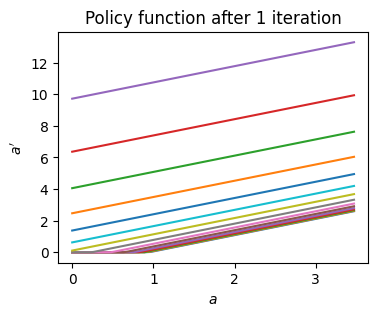

In [7]:
# plot policy function
fig, ax = plt.subplots()
for i_y in range(Grids.n_y):
    ax.plot(Grids.grid_a[0:40], a_prime[i_y, 0:40], label = f'y = {Grids.grid_y[i_y]:.2f}')
ax.set(xlabel = r'$a$', ylabel = r'$a^{\prime}$', title = 'Policy function after 1 iteration')
plt.show()

#### **Step 3** - Obtain $V_{t, a}$

In [8]:
V_a = (1 + model_params['r']) * c **(-1/model_params['eis']) # update value function derivative

### **Combine Steps into single Backward Iteration**
Now we write a function which takes as input a marginal value function, income and asset grids, preference parameters and transition matrices to compute a single backward iteration and output objects `V_a, a, c`.

In [9]:
def backward_iteration(V_a, beta, eis, r, grid_a, grid_y, Pi):

    n_y, n_a = grid_y.size, grid_a.size
    W = beta * Pi @ V_a

    c_endog = W ** (-1/eis)
    a_endog = (1 + r)**(-1) * (grid_a[np.newaxis, :] - grid_y[:, np.newaxis] + c_endog)
    a_prime = np.empty((n_y, n_a))

    for i_y in range(Grids.n_y):
        a_prime[i_y, :] = np.interp(grid_a, a_endog[i_y, :], grid_a)

    #a_prime = np.maximum(a_prime, Grids.grid_a[0]) # enforce borrowing constraint. actually not needed because interp already does this

    # obtain the consumption policy
    c = (1 + r) * (grid_a[np.newaxis, :] + grid_y[:, np.newaxis]) - a_prime

    return c, a_prime

# test the function
c, a_prime = backward_iteration(V_a, model_params['beta'], model_params['eis'], model_params['r'], Grids.grid_a, Grids.grid_y, Grids.Pi)

And we can solve the entire household problem for steady-state policies.

the steady state is unique.


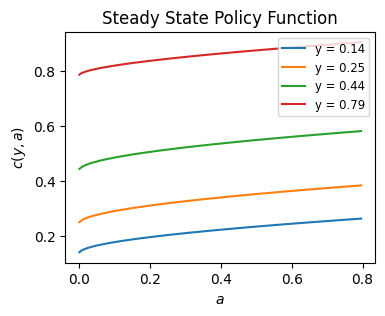

In [10]:
grid_params = {
    'n_y' : 7,
    'n_a' : 500,
    'min_a' : 0,
    'max_a' : 10_000
}

model_params = {
    'beta' : 1-0.08/4, # quarterly discount factor
    'r' : 0.01/4, # quarterly interest rate
    'eis' : 1,
    'rho' : 0.975,
    'sd_log_y' : 0.7
}

class SteadyStateHH:

    def __init__(self, model_params, grid_params, tol = 1e-6, max_iter = 1_000):
        self.model_params = model_params
        self.grid_params = grid_params
        self.Grids = Grid(n_y = grid_params['n_y'], rho = model_params['rho'],  sd_log_y = model_params['sd_log_y'], n_a = grid_params['n_a'], min_a = grid_params['min_a'], max_a = grid_params['max_a'])
        self.tol = tol
        self.max_iter = max_iter
        self.c = None
        self.a_prime = None
        self.V_a = None

    def backward_iteration(self, V_a):

        W = self.model_params['beta'] * self.Grids.Pi @ V_a

        c_endog = W ** (-1/self.model_params['eis'])
        a_endog = (1 + self.model_params['r'])**(-1) * (self.Grids.grid_a[np.newaxis, :] - self.Grids.grid_y[:, np.newaxis] + c_endog)
        a_prime = np.empty((self.grid_params['n_y'], self.grid_params['n_a']))

        for i_y in range(self.grid_params['n_y']):
            a_prime[i_y, :] = np.interp(self.Grids.grid_a, a_endog[i_y, :], self.Grids.grid_a)

        #a_prime = np.maximum(a_prime, self.Grids.grid_a[0]) 

        # obtain the consumption policy
        c = (1 + self.model_params['r']) * (self.Grids.grid_a[np.newaxis, :] + self.Grids.grid_y[:, np.newaxis]) - a_prime

        return c, a_prime
    
    def solve_ss(self):
            
        # initialize value function derivative with guess
        if self.V_a is None:
            V_a = np.ones((self.grid_params['n_y'], self.grid_params['n_a']))
        else:
            V_a = self.V_a

        for i in range(self.max_iter):
            c, a_prime = self.backward_iteration(V_a)
            V_a_new = (1 + self.model_params['r']) * c **(-1/self.model_params['eis'])

            if np.max(np.abs(V_a_new - V_a)) < self.tol:
                break

            V_a = V_a_new

        self.c = c
        self.a_prime = a_prime
        self.V_a = V_a

        return c, a_prime
    
    def plot_policy(self, bound_grid = 0.4):
        """ 
        Plot the policy function for the first 4 income states
        bound_grid: float, fraction of the grid to plot
        """
        rng_asset_grid = int(grid_params['n_a']*bound_grid)
        fig, ax = plt.subplots()
        for i_y, y in enumerate(self.Grids.grid_y[0:4]):
            ax.plot(self.Grids.grid_a[0:rng_asset_grid], self.c[i_y, 0:rng_asset_grid], label = f'y = {y:.2f}')
        ax.set(xlabel = r'$a$', ylabel = r'$c(y,a)$', title = 'Steady State Policy Function')
        plt.legend(fontsize = 'small')
        plt.show()

ss = SteadyStateHH(model_params, grid_params)
ss.solve_ss()
ss.c, ss.a_prime
ss.plot_policy(0.2)

**Exercise:** Refactor the code in order to use `@njit`.

In [11]:
from numba import njit

@njit
def backward_iteration(V_a, beta, eis, r, grid_a, grid_y, Pi):
    W = beta * Pi @ V_a

    c_endog = W ** (-1/eis)
    a_endog = (1 + r)**(-1) * (grid_a[np.newaxis, :] - grid_y[:, np.newaxis] + c_endog)
    a_prime = np.empty((grid_y.shape[0], grid_a.shape[0]))

    for i_y in range(grid_y.shape[0]):
        a_prime[i_y, :] = np.interp(grid_a, a_endog[i_y, :], grid_a)

    c = (1 + r) * (grid_a[np.newaxis, :] + grid_y[:, np.newaxis]) - a_prime

    return c, a_prime

class SteadyStateHH:

    def __init__(self, model_params, grid_params, tol = 1e-6, max_iter = 1_000):
        self.model_params = model_params
        self.grid_params = grid_params
        self.Grids = Grid(n_y = grid_params['n_y'], rho = model_params['rho'],  sd_log_y = model_params['sd_log_y'], n_a = grid_params['n_a'], min_a = grid_params['min_a'], max_a = grid_params['max_a'])
        self.tol = tol
        self.max_iter = max_iter
        self.c = None
        self.a_prime = None
        self.V_a = None

    # adding the model_params as an argument allows solving for different parameterizations
    def solve_ss(self, model_params):

        # update grid if necessary
        if (self.model_params['rho'], self.model_params['sd_log_y']) != (model_params['rho'], model_params['sd_log_y']):
            self.Grids = Grid(n_y = self.grid_params['n_y'], rho = model_params['rho'],  sd_log_y = model_params['sd_log_y'], n_a = self.grid_params['n_a'], min_a = self.grid_params['min_a'], max_a = self.grid_params['max_a'])
        # update model_params if necessary
        if self.model_params != model_params:
            self.model_params = model_params

        # initialize value function derivative with guess
        if self.V_a is None:
            V_a = np.ones((self.grid_params['n_y'], self.grid_params['n_a']))
        else:
            V_a = self.V_a

        for i in range(self.max_iter):
            c, a_prime = backward_iteration(V_a, model_params['beta'], model_params['eis'], model_params['r'], self.Grids.grid_a, self.Grids.grid_y, self.Grids.Pi)
            V_a_new = (1 + model_params['r']) * c **(-1/model_params['eis'])

            if np.max(np.abs(V_a_new - V_a)) < self.tol:
                break

            V_a = V_a_new

        self.c = c
        self.a_prime = a_prime
        self.V_a = V_a

        return c, a_prime
    
    def plot_policy(self, bound_grid = 0.4):
        """ 
        Plot the policy function for the first 4 income states
        bound_grid: float, fraction of the grid to plot
        """
        rng_asset_grid = int(grid_params['n_a']*bound_grid)
        fig, ax = plt.subplots()
        for i_y, y in enumerate(self.Grids.grid_y[0:4]):
            ax.plot(self.Grids.grid_a[0:rng_asset_grid], self.c[i_y, 0:rng_asset_grid], label = f'y = {y:.2f}')
        ax.set(xlabel = r'$a$', ylabel = r'$c(y,a)$', title = 'Steady State Policy Function')
        plt.legend(fontsize = 'small')
        plt.show()

the steady state is unique.


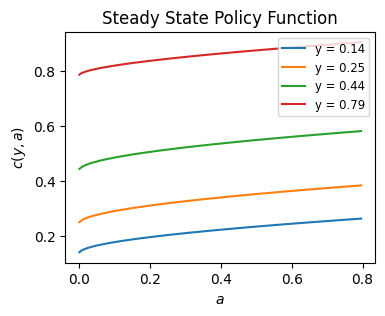

In [12]:
ss = SteadyStateHH(model_params, grid_params)
ss.solve_ss(model_params=ss.model_params)
ss.c, ss.a_prime
ss.plot_policy(0.2)

In [17]:
%%timeit 
ss = SteadyStateHH(model_params, grid_params)
ss.solve_ss(model_params=ss.model_params)

the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is unique.
the steady state is 

In [16]:
ss.solve_ss(model_params=ss.model_params)

(array([[1.41722822e-01, 1.46412415e-01, 1.50292317e-01, ...,
         1.86182818e+02, 1.94981292e+02, 2.04215800e+02],
        [2.50991933e-01, 2.55681526e-01, 2.60415096e-01, ...,
         1.86403939e+02, 1.95202357e+02, 2.04436700e+02],
        [4.44508157e-01, 4.49197750e-01, 4.53931320e-01, ...,
         1.86684758e+02, 1.95483026e+02, 2.04717044e+02],
        ...,
        [1.34562866e+00, 1.34617631e+00, 1.34672238e+00, ...,
         1.87539703e+02, 1.96337168e+02, 2.05569687e+02],
        [2.11335992e+00, 2.11362938e+00, 2.11390126e+00, ...,
         1.88211194e+02, 1.97007799e+02, 2.06238802e+02],
        [3.17854812e+00, 3.17874042e+00, 3.17893450e+00, ...,
         1.89156862e+02, 1.97952041e+02, 2.07180594e+02]]),
 array([[0.00000000e+00, 0.00000000e+00, 8.53668052e-04, ...,
         8.93360537e+03, 9.36572181e+03, 9.82092592e+03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.93349352e+03, 9.36561001e+03, 9.82081429e+03],
        [0.00000000e+00, 

## 3. **Forward Iteration to Obtain Distribution**

With steady-state policies at hand, we can compute the distribution of next-period asset holdings, $D_{t+1}(y, a)$ given the current distribution $D_t$. Assume for a moment that $a'$ maps assets on the grid $\mathcal A$. Then 

$$D_{t+1}(y, a) = \sum_{\bar y \in \mathcal Y} \sum_{\bar a \in \mathcal A} D_{t}(\bar y, \bar a) \mathbb P(\bar y | y) \mathbb I(a'(\bar y, \bar a) = a) $$

Problem: $a'(e, a)$ does not map into $\mathcal A$. Possible solution: **Lotteries**.

Basic idea is that if $a'(e, a) = a' \in [a_i, a_{i+1}]$ for two consecutive grid points $a_i, a_{i+1}$, then a fraction $q(y, a) = \frac{a_{i+1} - a'}{a_{i+1} - a_{i}}$ of the population lands on the lower gridpoint.

<!-- Start with a discretized distribution with mass on each gridpoint, $D_t(e, a)$. Then send $p(e, a)$ of mass to gridpoint $i(e, a)$ and $1-p(e, a)$ to gridpoint $i(e, a)+1$.   -->

Let $a^+$ be the next highest grid point on the asset grid, and $a^-$ the next lowest. 

$$\begin{align}
D_{t+1}(y, a) &= \sum_{\bar y \in \mathcal Y} \sum_{\bar a \in \mathcal A} D_{t}(\bar y, \bar a) \mathbb P(\bar y | y) \underbrace{\left[ \mathbb I(a'(\bar y, \bar a)^+ = a) \frac{ a' - a^-}{a^+ - a^-} + \mathbb I(a'(\bar y, \bar a)^- = a) \frac{ a^+ - a'}{a^+ - a^-} \right]}_{\equiv \mu( \bar y, \bar a, a)} \\
&= \sum_{\bar y \in \mathcal Y} \sum_{\bar a \in \mathcal A} D_{t}(\bar y, \bar a) \mu( \bar y, \bar a, a) \mathbb P(\bar y | y) \\
&= \sum_{\bar y \in \mathcal Y}  \mathbb P(\bar y | y) \sum_{\bar a \in \mathcal A} D_{t}(\bar y, \bar a) \mu( \bar y, \bar a, a) 
\end{align}$$

We can pre-compute the lottery array $\mu$ to handle the forward iteration. Still, this approach is very inefficient.

**Exercise:** Explain what is so inefficient about our approach?

**Exercise:** Write a function to compute `mu`

In [19]:
# Inefficient way to compute lotteries
@njit
def get_mu(policy, grid_a, grid_y):

    assert (policy - grid_a.max()).max() <= 0 and (policy - grid_a.min()).min() >= 0 # make sure policy is within bounds of grid_a

    n_a = np.shape(grid_a)[0]
    n_y = np.shape(grid_y)[0]
    mu = np.zeros((n_y, n_a, n_a), dtype=np.float64)
    for index_a in range(len(grid_a)):
        for index_a_bar in range(len(grid_a)):
            for index_y_bar in range(len(grid_y)):
                
                if (grid_a[index_a] >= policy[index_y_bar, index_a_bar]) and (grid_a[index_a - 1] <= policy[index_y_bar, index_a_bar]) :
                    p_plus = (policy[index_y_bar, index_a_bar] - grid_a[index_a - 1]) / (grid_a[index_a] - grid_a[index_a-1])
                    mu[index_y_bar, index_a_bar, index_a]   += p_plus 
                    continue
                
                if (grid_a[index_a] <= policy[index_y_bar, index_a_bar]) and (grid_a[index_a + 1] >= policy[index_y_bar, index_a_bar]) :
                    p_minus = (grid_a[index_a + 1] - policy[index_y_bar, index_a_bar]) / (grid_a[index_a+1] - grid_a[index_a])
                    mu[index_y_bar, index_a_bar, index_a]   += p_minus 
                    continue

    return mu

mu = get_mu(ss.a_prime, ss.Grids.grid_a, ss.Grids.grid_y)




%timeit get_mu(policy, grid_a, grid_y)

AttributeError: 'SteadyStateHH' object has no attribute 'policy'

Instead, consider where the mass of $D_t(y, a)$ is sent to. For $y$ fixed, $D_t(y, a) \dfrac{a'(y, a) - a'(y, a)^-}{a'(y, a)^+ - a'(y, a)^-} = D_t(y, a) q(y, a)$ is sent to $a'(y, a)^+$ and $D_t(y, a) (1-q(y, a))$ is sent to $a'(y, a)^-$. Proceeding over all $(y, a)$, we obtain $\tilde D_t(\cdot, \cdot)$, the distribution after asset choices were made and before income shocks realized.

We now write a function to obtain the $q$ (the lotteries) and the indices of $a'(y, a)^+$, where the masses in the distribution are sent to. Once we got `q` and `indexes`, we can use these objects in every forward iteration on $D_t$.

In [20]:
def get_lotteries(policy, grid_a):

    indexes = np.searchsorted(grid_a, policy) # indexes corresponding to a'(y, a)+  (function returns i with a[i-1] < v <= a[i])
    q = (policy - grid_a[indexes - 1]) / (grid_a[indexes] - grid_a[indexes - 1]) # lotteries
    return indexes, q

# forward iteration
@njit
def forward_iteration(indexes, q, Pi, D):
    n_y, n_a = D.shape
    D_new = np.zeros((n_y, n_a))
    for y in range(n_y):
        for a in range(n_a):
            
            D_new[y, indexes[y, a]]   += q[y, a] * D[y, a]
            D_new[y, indexes[y, a]-1]     += (1 - q[y, a]) * D[y, a]

    # D_new is D_tilde right now. Now we need to update D_tilde using Pi
    D_new = Pi @ D_new

    return D_new

forward_iteration(indexes, q, Pi, D)

NameError: name 'indexes' is not defined

Note that, when calculating `D_new = Pi @ D_new`, row $i_y$ corresponding to state $y$ will hold the vector 
$$[\Pi \tilde D]_{i_y} = (\pi(i_y, 1), ...,\pi(i_y, n_y)) \tilde D = [\pi(i_y, 1)\tilde D(1, i_a) + ... +\pi(i_y, n_y)\tilde D(n_y, i_a)]_{i_a =1,...,n_a}.$$

Finally, we compute the steady state distribution by iterating until convergence:

In [ ]:
def distribution_ss(Pi, policy, grid_a, maxiter=10_000, tol=1E-10, verbose=False):
    
    indexes, q = get_lotteries(policy, grid_a)

    # initialize distribution
    D = np.ones_like(policy)/np.size(policy)

    count, error = 0, 1
    while error > tol and count < maxiter:
        D_new = forward_iteration(indexes, q, Pi, D)
        error = np.max(np.abs(D - D_new))
        D = D_new.copy()
        count += 1
        
    
    if verbose : 
        print("max |D_t - D_t+1| = ", error, "\nnum iterations:", count)

    return D

In [ ]:
D_ss = distribution_ss(Pi, policy, grid_a, maxiter=1000, tol=1E-10, verbose=True)

%timeit distribution_ss(Pi, policy, grid_a, maxiter=1000, tol=1E-10, verbose=False)

### **Using the SteadyStateHH Module**

**Exercise:** Add the computation of steady state $D$ to the `SteadyStateHH` class. Import it from another file and run it.

Note: restart the kernel before re-importing the classes. 

In [ ]:
from utils_simm import *

grid_params = {
    'n_y' : 7,
    'n_a' : 500,
    'min_a' : 0,
    'max_a' : 10_000
}

model_params = {
    'beta' : 1-0.08/4, # quarterly discount factor
    'r' : 0.01/4, # quarterly interest rate
    'eis' : 1,
    'rho' : 0.975,
    'sd_log_y' : 0.7
}

print(model_params, "\n",grid_params, sep="")
# create steady state object
ss = SteadyStateHH(model_params, grid_params)

In [ ]:
# solve for steady state
ss.solve_ss(ss.model_params)

ss.distribution_ss()